In [119]:
import os
import numpy as np
from astropy.io import fits
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
plt.style.use('seaborn-white')
import plotly.plotly as py
import plotly.graph_objs as go
import pandas as pd
import seaborn as sns
import cufflinks as cf
from bokeh.plotting import figure, show, output_file
directory = '/Users/zach//GRB160625B.945_LAT-trigger_correlated-optical-polarized-emission/'
file_n5 = 'glg_cspec_n5_bn160625945_v01.rsp'
#file_n7 = 'glg_tte_n7_bn160625945_v00.fit'
#file_b1 = 'glg_tte_b1_bn160625945_v00.fit'

# HDU: Header Data Unit
hdu_n5 = fits.open(directory + file_n5)
#hdu_n7 = fits.open(directory + file_n7)


# print(hdu_n5.info())
#print(repr(hdu_n5['SPECRESP MATRIX'].header))
print(hdu_n5['SPECRESP MATRIX'].columns)
#print(hdu_n5['EBOUNDS'].columns)
#print(hdu_n2['SPECRESP MATRIX'].data)

ColDefs(
    name = 'ENERG_LO'; format = '1E'; unit = 'keV'
    name = 'ENERG_HI'; format = '1E'; unit = 'keV'
    name = 'N_GRP'; format = '1I'
    name = 'F_CHAN'; format = 'PI(1)'
    name = 'N_CHAN'; format = 'PI(1)'
    name = 'MATRIX'; format = 'PE(128)'; unit = 'cm**2'
)


In [120]:
# rmf file
ENERG_LO= hdu_n5['SPECRESP MATRIX'].data['ENERG_LO']
ENERG_HI= hdu_n5['SPECRESP MATRIX'].data['ENERG_HI']
N_GRP= hdu_n5['SPECRESP MATRIX'].data['N_GRP']
F_CHAN= hdu_n5['SPECRESP MATRIX'].data['F_CHAN']
MATRIX= hdu_n5['SPECRESP MATRIX'].data['MATRIX']
# arf file 
E_MIN= hdu_n5['EBOUNDS'].data['E_MIN']
E_MAX= hdu_n5['EBOUNDS'].data['E_MAX']
CHANNEL=hdu_n5['EBOUNDS'].data['CHANNEL']


In [121]:
EnergyArray=ENERG_LO
EnergyArray= np.append(EnergyArray,ENERG_HI[-1])

In [122]:
def myfunc(param,x):
    y = param[0]*(x**param[1])
    return np.array(y,dtype='float64')

Power_law_coeff=[1,-2]


In [123]:
NbPhoton_Sim= myfunc(Power_law_coeff,EnergyArray)
log_NbPhoton_Sim=list(map(lambda x: math.log10(x),NbPhoton_Sim))
#log_NbPhoton_Sim
log_EnergyArray=list(map(lambda x: math.log10(x),EnergyArray))

In [124]:
from scipy.integrate import quad
def integrand(x, a, b):
    
    return a * (x**b)

a = Power_law_coeff[0]
b = Power_law_coeff[1]
Integration_at_energy=[]
for i in range(len(EnergyArray)-1):
    I = quad(integrand,EnergyArray[i],EnergyArray[i+1], args=(a,b))
    Integration_at_energy.append(I[0])

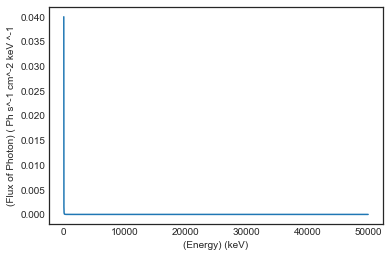

In [125]:
plt.plot(EnergyArray,NbPhoton_Sim)
plt.ylabel('(Flux of Photon) ( Ph s^-1 cm^-2 keV ^-1')
plt.xlabel('(Energy) (keV)')
plt.show()

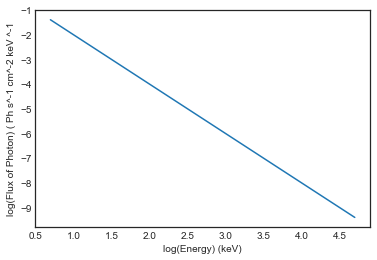

In [126]:
plt.plot(log_EnergyArray,log_NbPhoton_Sim)
plt.ylabel('log(Flux of Photon) ( Ph s^-1 cm^-2 keV ^-1')
plt.xlabel('log(Energy) (keV)')
plt.show()

In [127]:
df=pd.DataFrame(EnergyArray,columns=['EnergyArray'])
df['NbPhoton_Sim']=NbPhoton_Sim
df2=pd.DataFrame(Integration_at_energy,columns=['Integration_at_energy'])
df2['Energy range']=np.arange(140)

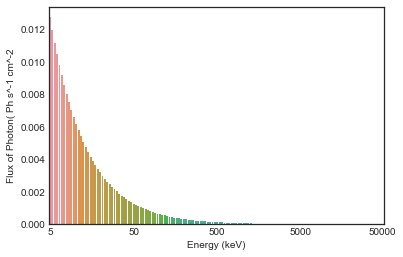

In [128]:
# Integrate against the energy. 
ax = sns.barplot(x="Energy range", y="Integration_at_energy", data=df2)
ax.set(xlabel='Energy (keV)', ylabel='Flux of Photon( Ph s^-1 cm^-2')
#ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
x_pos_list = np.array([0,35,70,105,139])
x_value_list = ('5', '50', '500', '5000','50000')
ax.xaxis.set_major_locator(ticker.FixedLocator((x_pos_list)))
ax.xaxis.set_major_formatter(ticker.FixedFormatter((x_value_list)))
plt.show()

In [129]:
# to gert the avg value of range between E1 and E2. 
#EnergyArray_for_bar_list=[]
#for i in range(len(EnergyArray)):
    #if i<len(EnergyArray)-1:
        #EnergyArray_for_bar=(myfunc(Power_law_coeff,EnergyArray[i+1])+myfunc(Power_law_coeff,EnergyArray[i]))/2
        #EnergyArray_for_bar_list.append(EnergyArray_for_bar) 

In [130]:
# Area
#photon_area = np.zeros(140)
#for i, _ in enumerate(NbPhoton_Sim):
    #if i == (len(NbPhoton_Sim) - 1):
        #break
   # elem = np.append(NbPhoton_Sim[i], NbPhoton_Sim[i+1])
   # photon_area[i] = np.trapz(elem, dx=2)

In [131]:
matrix= np.zeros(shape=(140,128))
for i in range(len(MATRIX)):
    if MATRIX[i][0]==0:
        matrix[i]=[0]*128
    else:
        matrix[i]=MATRIX[i]
    # normalization
#for i in range(len(matrix)):
        #if matrix[i][0]!=0:
            #matrix[i] = matrix[i]/sum(matrix[i])
#print(matrix)
matrix_trans=matrix.transpose()

In [132]:
# Find the solution within the linear system. Or doesn't need this. 
#a = matrix
#b = NbPhoton_Sim
#x = np.linalg.solve(a, b)

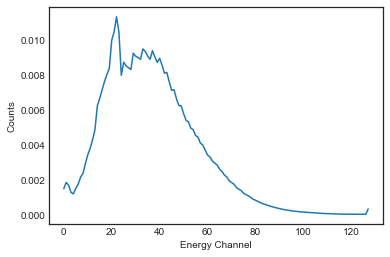

In [133]:
a = Integration_at_energy
b = matrix
Channel=np.dot(a, b)
plt.plot(Channel)
plt.ylabel('Counts')
plt.xlabel('Energy Channel')
plt.show()

In [139]:
print(len(matrix_trans[10]))
print(len(matrix_trans))

140
128


In [134]:
# Derive the  140 x 120 values. 
value_list=[]
for i in range(len(matrix_trans)):
    for j in range(len(matrix_trans[i])):
        value= (Integration_at_energy[j]) * matrix_trans[i][j]
        value_list.append(value)

In [135]:
value_array=np.array(value_list)
value_matrix=value_array.reshape(128,140)
#np.sum(value_matrix[100])

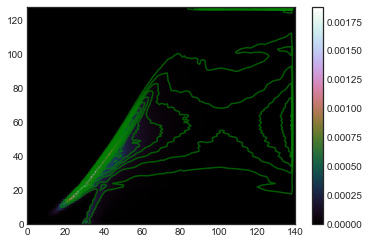

In [141]:
fig=plt.figure()
ax1=plt.pcolormesh(value_matrix, cmap=plt.get_cmap('cubehelix'))
plt.colorbar()
curves =20
m = max([max(row) for row in matrix])
levels = np.arange(0, m, (1 / float(curves)) * m)
plt.contour(matrix_trans, colors="g", levels=levels,alpha=0.7)
plt.show()

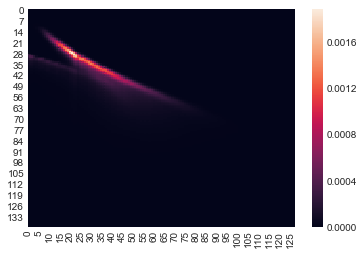

In [147]:
ax = sns.heatmap(value_matrix.transpose())
plt.show()